In [7]:
!pip install tensorflow==2.4.1 opencv-python mediapipe sklearn matplotlib

In [4]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [6]:
import cv2
import numpy as np
import os 
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [ ]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  # Image is no longer writeable
    
    result = model.process(image)                 # Make prediction
    
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, result

In [ ]:
def draw_landmarks(image, result):
    # Draw face connections
    mp_drawing.draw_landmarks(image, result.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, result.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, result.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, result.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, result = mediapipe_detection(frame, holistic)
               
        # Draw landmarks
        draw_landmarks(image, result)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
draw_landmarks(frame, result)

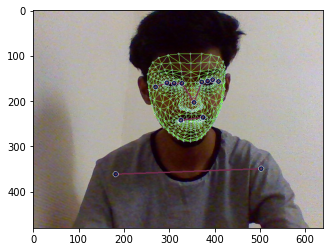

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
print(len(result.pose_landmarks.landmark))
print(len(result.face_landmarks.landmark))
print(len(result.left_hand_landmarks.landmark))

In [ ]:
def extract_keypoints(result):
    
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33,4)
    face = np.array([[res.x,res.y,res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x,res.y,res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x,res.y,res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose,face,lh,rh])

In [ ]:
test=extract_keypoints(result)

In [ ]:
test

array([ 0.53685057,  0.47195107, -1.46747172, ...,  0.        ,
        0.        ,  0.        ])

In [ ]:
data_path = os.path.join("hand_detection")
actions = np.array(['hello','love you','thank you'])
no_sequences = 30
sequence_length = 30


In [ ]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(data_path,action,str(sequence)))
        except:
            pass
            

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                
                ret,frame= cap.read()
                image, result = mediapipe_detection(frame, holistic)
                draw_landmarks(image, result)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                keypoints= extract_keypoints(result)
                npy_path = os.path.join(data_path,action, str(sequence),str(frame_num))
                np.save(npy_path, keypoints)
            
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                                
                                
    cap.release()
    cv2.destroyAllWindows()                            
                                
                    
                
                
    

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label = {label:num for num,label in enumerate(actions)} 

In [ ]:
label

{'hello': 0, 'love you': 1, 'thank you': 2}

In [ ]:
labels,sequences=[],[]
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(data_path,action))):
        windows=[]
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path,action,str(sequence),'{}.npy'.format(frame_num)))
            windows.append(res)
        sequences.append(windows)
        labels.append(label[action])

In [ ]:
print(len(sequences))
print(len(labels))

90
90


In [ ]:
np.array(sequences).shape

(90, 30, 1662)

In [ ]:
np.array(labels).shape

(90,)

In [ ]:
X = np.array(sequences)

In [ ]:
y = to_categorical(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join('log_dirs_second')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train,y_train,epochs=148,callbacks=[tb_callback])

Epoch 1/148
3/3 [==============================] - 1s 521ms/step - loss: 5.2844 - categorical_accuracy: 0.4118
Epoch 2/148
3/3 [==============================] - 0s 101ms/step - loss: 7.7493 - categorical_accuracy: 0.3059
Epoch 3/148
3/3 [==============================] - 0s 102ms/step - loss: 8.9143 - categorical_accuracy: 0.3059
Epoch 4/148
3/3 [==============================] - 0s 90ms/step - loss: 11.2123 - categorical_accuracy: 0.3294
Epoch 5/148
3/3 [==============================] - 0s 100ms/step - loss: 3.9425 - categorical_accuracy: 0.2706
Epoch 6/148
3/3 [==============================] - 0s 99ms/step - loss: 5.2487 - categorical_accuracy: 0.2941
Epoch 7/148
3/3 [==============================] - 0s 95ms/step - loss: 14.2655 - categorical_accuracy: 0.1765
Epoch 8/148
3/3 [==============================] - 0s 98ms/step - loss: 10.8752 - categorical_accuracy: 0.4941
Epoch 9/148
3/3 [==============================] - 0s 92ms/step - loss: 17.9962 - categorical_accuracy: 0.3529
Ep

3/3 [==============================] - 0s 100ms/step - loss: 0.0867 - categorical_accuracy: 0.9882
Epoch 75/148
3/3 [==============================] - 0s 97ms/step - loss: 0.0765 - categorical_accuracy: 0.9882
Epoch 76/148
3/3 [==============================] - 0s 93ms/step - loss: 0.0735 - categorical_accuracy: 0.9882
Epoch 77/148
3/3 [==============================] - 0s 90ms/step - loss: 0.0720 - categorical_accuracy: 0.9882
Epoch 78/148
3/3 [==============================] - 0s 95ms/step - loss: 0.0740 - categorical_accuracy: 0.9882
Epoch 79/148
3/3 [==============================] - 0s 109ms/step - loss: 0.0715 - categorical_accuracy: 0.9882
Epoch 80/148
3/3 [==============================] - 0s 95ms/step - loss: 0.0655 - categorical_accuracy: 0.9882
Epoch 81/148
3/3 [==============================] - 0s 93ms/step - loss: 0.0707 - categorical_accuracy: 0.9882
Epoch 82/148
3/3 [==============================] - 0s 95ms/step - loss: 0.0704 - categorical_accuracy: 0.9882
Epoch 83/148

3/3 [==============================] - 0s 105ms/step - loss: 0.0487 - categorical_accuracy: 0.9882
Epoch 147/148
3/3 [==============================] - 0s 96ms/step - loss: 0.0496 - categorical_accuracy: 0.9882
Epoch 148/148
3/3 [==============================] - 0s 110ms/step - loss: 0.0489 - categorical_accuracy: 0.9882


In [ ]:
res= model.predict(X_test)

In [ ]:
actions[np.argmax(res[2])]

'hello'

In [ ]:
actions[np.argmax(y_test[2])]

'hello'

In [ ]:
model.save('models/hand_detection.h5')

INFERENCE

In [ ]:
model.load_weights('models/hand_detection.h5')

In [21]:
res= model.predict(X_test)

In [22]:
actions[np.argmax(res[2])]

'hello'

In [23]:
actions[np.argmax(y_test[2])]

'hello'

In [54]:
from scipy import stats
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [61]:
sequence =[]
sentence= []
threshold = 0.6
predictions=[]


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, result = mediapipe_detection(frame, holistic)
               
        # Draw landmarks
        draw_landmarks(image, result)
        
        keypoints = extract_keypoints(result)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence,axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
            image = prob_viz(res, actions, image, colors)
                
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
love you
hello
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love you
love yo